Analysis of Dota2 game statistics through Dota 2 match data from Open Dota
Data Collected:
1. Hero Data:
    1.1 Hero Statistics data
    1.2 Hero Lore
2. Match Data:
    2.1 Parsed Match data
3. 1 player data
4. Resources related to data

Data Collection Steps:

1. Python script is generated to run and fetch match ids, and detailed data of around 10,000 matches with accordance to OpenDota API limit.
    This working code can be found in our git repo https://github.com/AdityaHegde23/Dota-Stats also this code is added below for reference
2. Collected raw data is then stored in json format.
3. Futher Data cleaning, normalizing and EDA steps are in this following notebook
Data Collection Steps:


In [2]:
# Data collection code. This code runs everyday to fetch data based on API limit of Open data.
'''
import os
import json
import requests
from datetime import datetime
import time

# Configuration
API_ENDPOINT = "https://api.opendota.com/api/matches/{match_id}"
API_KEY = "YOUR_OPENDOTA_API_KEY"  # Replace with your OpenDota API key, if needed
LOCAL_SAVE_DIR = "/home/ad-magus-apex/Downloads/Q4/EDA/dota-stats/match_data/parsed_matches/parsed_match_data"  # Local directory to save JSON files
RATE_LIMIT = 60  # Number of requests per minute

def fetch_and_save_match_data(match_id):
    """Fetches match data from OpenDota API and saves it locally as a JSON file."""
    try:
        # Fetch data from API
        response = requests.get(API_ENDPOINT.format(match_id=match_id))
        response.raise_for_status()
        match_data = response.json()

        # Prepare filename and path
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        filename = f"match_{match_id}_{timestamp}.json"
        #filename = "pubic_match_data.json"
        local_path = os.path.join(LOCAL_SAVE_DIR, filename)

        # Ensure local directory exists
        os.makedirs(LOCAL_SAVE_DIR, exist_ok=True)
        print("Writing data to disk")
        # Save data locally
        with open(local_path, 'w') as f:
            json.dump(match_data, f, indent=4)
        print(f"Match data saved locally: {local_path}")

    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch match data for match_id {match_id}: {e}")


def fetch_and_save_match_ids(preferred_id, target_count=10000):
    url = "https://api.opendota.com/api/parsedMatches"
    match_ids = []
    calls_per_day = 2000
    rate_limit = 60  # 60 calls per minute
    request_interval = 60 / rate_limit  # Interval in seconds per request

    while len(match_ids) < target_count:
        params = {"less_than_match_id": preferred_id}
        response = requests.get(url, params=params)

        if response.status_code == 200:
            data = response.json()
            if not data:
                print("No more matches available to fetch.")
                break

            # Extract match IDs and update preferred_id
            for match in data:
                match_id = match["match_id"]
                match_ids.append(match_id)

            # Update preferred_id to fetch the next batch of older matches
            preferred_id = match_ids[-1]  # Get the last match ID fetched for the next request
            print(preferred_id)
            print(f"Fetched {len(match_ids)} match IDs so far...")

            # # Check if we reached the call limit
            # if len(match_ids)/100 >= calls_per_day:
            #     print("Reached daily call limit. Waiting until tomorrow...")
            #     time.sleep(24 * 60 * 60)  # Wait for a day if the daily call limit is reached

            # Wait to avoid rate limiting
            time.sleep(request_interval)

        else:
            print(f"Failed to fetch data. Status code: {response.status_code}")
            time.sleep(request_interval)

    ids_dir_path = "/home/ad-magus-apex/Downloads/Q4/EDA/dota-stats/data/match_data/parsed_matches/parsed_match_ids_new.json"
    # Save match IDs to file
    with open(ids_dir_path, "w") as f:
        json.dump(match_ids, f)
    print(f"Saved {target_count} match IDs")


def extract_match_ids():
    """Extracts match IDs from a locally stored JSON file."""
    preferred_id = 8014987338
    match_ids_path = f"match_data/parsed_matches/parsed_matches.json"
    with open(match_ids_path, 'r') as f:
        data = json.load(f)

    # Extract match IDs
    match_ids = [match["match_id"] for match in data if "match_id" in match]
    print(match_ids[0])
    # Print match IDs
    #print("Extracted match IDs:", match_ids)

    return match_ids

def fetch_matches_in_sequence():
    """Fetch multiple match data sequentially with rate limiting."""

    match_ids = extract_match_ids()
    for match_id in match_ids:

        fetch_and_save_match_data(match_id)

        # Rate limit to avoid hitting API limits (2000 calls/day at 60 calls/min)
        time.sleep(60 / RATE_LIMIT)

# Example usage
start_match_id = 8008769471  # Replace with a valid starting match ID
num_matches = 110  # Number of matches to fetch

fetch_and_save_match_ids(preferred_id=8035007566)

fetch_matches_in_sequence()
fetch_and_save_match_data()
'''

'\nimport os\nimport json\nimport requests\nfrom datetime import datetime\nimport time\n\n# Configuration\nAPI_ENDPOINT = "https://api.opendota.com/api/matches/{match_id}"\nAPI_KEY = "YOUR_OPENDOTA_API_KEY"  # Replace with your OpenDota API key, if needed\nLOCAL_SAVE_DIR = "/home/ad-magus-apex/Downloads/Q4/EDA/dota-stats/match_data/parsed_matches/parsed_match_data"  # Local directory to save JSON files\nRATE_LIMIT = 60  # Number of requests per minute\n\ndef fetch_and_save_match_data(match_id):\n    """Fetches match data from OpenDota API and saves it locally as a JSON file."""\n    try:\n        # Fetch data from API\n        response = requests.get(API_ENDPOINT.format(match_id=match_id))\n        response.raise_for_status()\n        match_data = response.json()\n\n        # Prepare filename and path\n        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")\n        filename = f"match_{match_id}_{timestamp}.json"\n        #filename = "pubic_match_data.json"\n        local_path

In [8]:
# Data Integration, Normalization, Cleaning and early EDA

import os
import json
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from math import comb

Hero Data Transform




In [ ]:
# Load hero statistics data
file_path = './data/hero_data/hero_stats/hero_stats.json'

with open(file_path, 'r') as f:
    hero_data = json.load(f)

df_hero_data = pd.json_normalize(hero_data)

# Now removing unnecessary columns like img, icon
df_hero_data = df_hero_data.drop(columns=['img', 'icon'])
df_hero_data.head()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x74ecc6ebf700>>
Traceback (most recent call last):
  File "/home/ad-magus-apex/Downloads/Q4/EDA/Dota-Stats/env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Processed 1000 files...


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x74ecc6ebf700>>
Traceback (most recent call last):
  File "/home/ad-magus-apex/Downloads/Q4/EDA/Dota-Stats/env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Processed 2000 files...


# **Public Match Data**

In [1]:
%pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 590.2 kB/s eta 0:00:00m eta 0:00:010:00:14
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 KB 3.9 MB/s eta 0:00:00 MB/s eta 0:00:01
Using legacy 'setup.py install' for pyspark, since package 'wheel' is not installed.
  Running setup.py install for pyspark ... done
Note: you may need to restart the kernel to use updated packages.


In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("JSON Batch Processing") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Folder containing JSON files
folder_path = "./data/match_data/parsed_matches/parsed_match_data"
batch_size = 3000  # Number of files per batch

# Get all JSON files in the directory
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.json')]

# Split files into batches
batches = [all_files[i:i + batch_size] for i in range(0, len(all_files), batch_size)]

dfs = []

for i, batch in enumerate(batches):
    print(f"Processing batch {i + 1}/{len(batches)} with {len(batch)} files...")
    try:
        # Read batch with permissive mode
        df_batch = spark.read.option("mode", "PERMISSIVE").json(batch)
        print(df_batch.head())
        # Drop unnecessary columns
        df_batch = df_batch.drop(*[col for col in df_batch.columns if 'cosmetics' in col or 'all_word_count' in col])

        # Append to DataFrame list
        dfs.append(df_batch)
    except Exception as e:
        print(f"Error processing batch {i + 1}: {e}")

# Union all DataFrames
df_pub_matches = dfs[0]
for df in dfs[1:]:
    df_pub_matches = df_pub_matches.union(df)

print("All match data extracted and concatenated.")
df_pub_matches.show(5)  # Inspect data
df_pub_matches.write.option("header", "true").csv("./data/outputs/intermediate_match_data", mode="overwrite")

spark.stop()


Processing batch 1/7 with 3000 files...


ERROR:root:KeyboardInterrupt while sending command.              (16 + 8) / 107]
Traceback (most recent call last):
  File "/home/ad-magus-apex/Downloads/Q4/EDA/Dota-Stats/env/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/ad-magus-apex/Downloads/Q4/EDA/Dota-Stats/env/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [5]:
df_pub_matches.show()

AnalysisException: Since Spark 2.3, the queries from raw JSON/CSV files are disallowed when the
referenced columns only include the internal corrupt record column
(named _corrupt_record by default). For example:
spark.read.schema(schema).csv(file).filter($"_corrupt_record".isNotNull).count()
and spark.read.schema(schema).csv(file).select("_corrupt_record").show().
Instead, you can cache or save the parsed results and then send the same query.
For example, val df = spark.read.schema(schema).csv(file).cache() and then
df.filter($"_corrupt_record".isNotNull).count().

In [ ]:
import pandas as pd
import os
import json

folder_path = "./data/match_data/parsed_matches/parsed_match_data"
batch_size = 3000  # Number of files per batch
all_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

match_data = []  # To store batch data
dfs = []         # To store concatenated batches

for i, filename in enumerate(all_files):
    file_path = os.path.join(folder_path, filename)

    with open(file_path, 'r') as file:
        data = json.load(file)
        df = pd.json_normalize(data)  # Convert JSON to DataFrame
        df = df.drop(df.filter(regex='^cosmetics|^all_word_count').columns, axis=1)
        match_data.append(df)
    file.close()
    if (i + 1) % batch_size == 0 or (i + 1) == len(all_files):
        dfs.append(pd.concat(match_data, ignore_index=True))
        match_data = []  # Clear batch data from memory
        print(f'Processed {i + 1} files...')

df_pub_matches = pd.concat(dfs, ignore_index=True)  # Final concatenation
print('All match data extracted and concatenated.')


Processed 3000 files...
Processed 6000 files...
Processed 9000 files...
Processed 12000 files...
Processed 15000 files...


In [ ]:
df_pub_matches.to_csv("./data/outputs/pub_matches.csv", index=False)

In [ ]:
dddd

In [ ]:
folder_path = "./data/match_data/parsed_matches/parsed_match_data"
match_data = [] # To store all match data
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        file_path = os.path.join(folder_path, filename)

        # Open and load JSON data
        with open(file_path, 'r') as file:
            data = json.load(file)
            df = pd.json_normalize(data)  # Convert JSON to DataFrame
            # Lets drop not needed columns
            df = df.drop(df.filter(regex='^cosmetics|^all_word_count').columns, axis=1)
            match_data.append(df)  # Append to list
print('match data extracted from json')
# Now concat all matches into one data frame
df_pub_matches = pd.concat(match_data, ignore_index=True)
df_pub_matches.to_csv("./data/outputs/pub_matches.csv", index=False)

print('df_pub_matches initialized')
df_pub_matches = df_pub_matches[(df_pub_matches['game_mode'] == 22) | (df_pub_matches['game_mode'] == 4)].reset_index(drop=True) # all pick
#df_pub_matches_turbo = df_pub_matches[df_pub_matches['game_mode'] == 23].reset_index(drop=True)
print('turbo and all pick seperated')
# Removing some more columns
df_pub_matches = df_pub_matches.drop(columns=['draft_timings','teamfights','version','leagueid','series_id','series_type','engine','replay_url','od_data.has_api','od_data.has_gcdata','od_data.has_parsed','human_players','match_seq_num'])
# Storing back to csv
print('columns dropped')
df_pub_matches.to_csv("./data/outputs/intermediate_match_data.csv", index=False)

# Lets seperates Objectives took place for each match across time to different data frame
objectives_data = df_pub_matches[['match_id','objectives']]

rows = [] # To store each objectives
for index, row in df.iterrows():
    match_id = row["match_id"]
    for obj in row["objectives"]:
        row = {
            "match_id": match_id,
            "time": obj.get("time"),
            "slot": obj.get("slot"),
            "type": obj.get("type"),
            "unit": obj.get("unit"),
            "key": obj.get("key"),
            "player_slot": obj.get("player_slot")
        }
        rows.append(row)

# Create DataFrame
df_match_objectives = pd.DataFrame(rows)
# Storing objectives to csv
df_match_objectives.to_csv("./data/outputs/match_objectives.csv", index=False)


# Lets seperate chat from main data frame

all_chat = df_pub_matches[['match_id','chat']]

rows = [] # To store each match chat
for index, row in df.iterrows():
    match_id = row["match_id"]
    for chat in row["chat"]:
        row = {
            "match_id": match_id,
            "time": obj.get("time"),
            "slot": obj.get("slot"),
            "type": obj.get("type"),
            "key": obj.get("key"),
            "player_slot": obj.get("player_slot")
        }
        rows.append(row)

# Create DataFrame
df_match_all_chat = pd.DataFrame(rows)
# Storing objectives to csv
df_match_all_chat.to_csv("./data/outputs/match_all_chat.csv", index=False)


# Lets seperates hero picks and bans details from main DF
picks_bans = df_pub_matches[['match_id','picks_bans']]

rows = [] # To store each objectives
for index, row in df.iterrows():
    match_id = row["match_id"]
    for pb in row["objectives"]:
        row = {
            "match_id": match_id,
            "is_pick": obj.get("is_pick"),
            "hero_id": obj.get("hero_id"),
            "team": obj.get("team"),
            "order": obj.get("order"),
        }
        rows.append(row)

# Lets seperates players from main DF
df_players = df_pub_matches[['match_id','players']]

# Now we can drop objectives and chat from out main DF
df_pub_matches = df_pub_matches.drop(columns=['objectives', 'chat', 'players', 'picks_bans'])


match_8033570080.json
match_8034775507.json
match_8034843521.json
match_8034733055.json
match_8034898274.json
match_8034787647.json
match_8034645886.json
match_8033932210.json
match_8033765218.json
match_8033501850.json
match_8034627772.json
match_8034699489.json
match_8033569981.json
match_8034510215.json
match_8033755598.json
match_8033661037.json
match_8033792546.json
match_8034422829.json
match_8034364115.json
match_8033621378.json
match_8034830016.json
match_8034662451.json
match_8034998682.json
match_8034698753.json
match_8033996832.json
match_8034426992.json
match_8033735389.json
match_8034625646.json
match_8034380498.json
match_8033589212.json
match_8033599389.json
match_8034150652.json
match_8034473211.json
match_8034797793.json
match_8034849011.json
match_8034661265.json
match_8033518147.json
match_8034360218.json
match_8033665262.json
match_8034831515.json
match_8034355290.json
match_8034604085.json
match_8033625475.json
match_8033518782.json
match_8034339109.json
match_8034

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x779149c5f700>>
Traceback (most recent call last):
  File "/home/ad-magus-apex/Downloads/Q4/EDA/Dota-Stats/env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


match_8034956703.json
match_8034055672.json
match_8034976288.json
match_8034787498.json
match_8034154385.json
match_8034735950.json
match_8034434883.json
match_8034520399.json
match_8034026913.json
match_8033804921.json
match_8033692946.json
match_8034108212.json
match_8034182148.json
match_8034870972.json
match_8033582536.json
match_8033759814.json
match_8034636106.json
match_8033801271.json
match_8034047154.json
match_8034507466.json
match_8034911588.json
match_8034560325.json
match_8033548219.json
match_8033616709.json
match_8033537542.json
match_8034753764.json
match_8034147114.json
match_8033675243.json
match_8034732379.json
match_8033927769.json
match_8033619505.json
match_8034812380.json
match_8034893166.json
match_8034936243.json
match_8034755385.json
match_8034379304.json
match_8034106315.json
match_8033983717.json
match_8033606653.json
match_8033964817.json
match_8034078719.json
match_8034589120.json
match_8034484323.json
match_8034705437.json
match_8033796074.json
match_8034

In [285]:
# Converting Game date into readable format
# Right now Game start time is in Unix timestamp format

df_pub_matches['start_time'] = pd.to_datetime(df_pub_matches['start_time'], unit='s')
df_pub_matches.head()

# Change the Winner into proper format that is to Radiant / Dire

df_pub_matches['Winner'] = df_pub_matches['radiant_win'].map({True: 'Radiant', False: 'Dire'})

In [286]:
# Filling NaN for Not available values

df_pub_matches['throw'] = df_pub_matches['throw'].fillna(np.nan)
df_pub_matches['loss'] = df_pub_matches['loss'].fillna(np.nan)
df_pub_matches['comeback'] = df_pub_matches['comeback'].fillna(np.nan)
df_pub_matches['stomp'] = df_pub_matches['stomp'].fillna(np.nan)
df_pub_matches.head()

,match_id,radiant_gold_adv,radiant_xp_adv,start_time,duration,cluster,replay_salt,radiant_win,pre_game_duration,tower_status_radiant,...,radiant_score,dire_score,metadata,patch,region,comeback,stomp,throw,loss,Winner
0,8008996301,"[0, 680, 829, 634, 366, 1152, 772, 1890, 1741,...","[0, 138, 654, 504, 586, 1025, 844, 1554, 1271,...",2024-10-28 20:28:10,1642,184,2137628625,True,90,1982,...,46,22,None,56,8.0,NaN,NaN,0.0,28983.0,Radiant
1,8009005293,"[-100, -463, -905, -464, -496, -1141, -1735, -...","[-68, -55, -479, -157, 155, -114, -637, -954, ...",2024-10-28 20:35:59,1821,185,1682308800,False,90,0,...,23,42,None,56,8.0,-100.0,19785.0,NaN,NaN,Dire
2,8009005231,"[0, -165, -373, -17, 1056, 843, 1080, 27, 2106...","[0, 265, 71, 555, 630, 507, 775, 212, 3138, 24...",2024-10-28 20:35:55,1376,152,153036417,True,90,2047,...,50,20,None,56,5.0,NaN,NaN,373.0,21267.0,Radiant
3,8009004548,"[0, -1157, -641, -1299, -939, -1983, -3296, -4...","[0, -31, 309, -671, -341, -1014, -1973, -2543,...",2024-10-28 20:35:05,999,122,34594305,False,90,391,...,9,31,None,56,2.0,0.0,16741.0,NaN,NaN,Dire
4,8009000279,"[0, -343, -434, -304, -134, -880, -398, -1300,...","[0, 89, 380, 119, 813, -381, 252, -525, -106, ...",2024-10-28 20:31:09,1606,181,1700251541,False,90,0,...,14,39,None,56,8.0,0.0,27958.0,NaN,NaN,Dire


In [287]:
#Heros

# Hero winrates /done
# Hero bans /ND
# Lore /done

# Matches
# Kills -> wins  /done
# Gold and XP adv /done
# combination of hero best /done
# combination of hero worst /done

#Players
# sorted by region? /ND
# Day and night? /done
# MUP - BLAME => who played each hero on loosing side (player_id) -> get player data -> Count the no. times each loosing player played that hero
#                -> highest number is to blame
 

In [288]:
df_hero_winrate = pd.DataFrame()

In [289]:

# Total number of heroes
total_heroes = 126

# Combination of 5 heroes for one team
team_comb = comb(total_heroes, 5)

# Combination for both teams (heroes can't repeat between teams)
both_team_comb = team_comb * comb(total_heroes - 5, 5)

team_comb, both_team_comb


(244222650, 48549654107054100)

In [290]:
df_hero_winrate = df_hero_data[['id', 'localized_name', 'pub_pick']].copy()
df_hero_winrate['pub_winrate'] = df_hero_data['pub_win'] / df_hero_data['pub_pick'] * 100

# for i in range(1,9):
#     df_hero_winrate[f'{i}_pick_winrate'] = df_hero_data[f'{i}_win'] / df_hero_data[f'{i}_pick'] * 100

In [291]:
# df_hero_winrate['best_pick'] = df_hero_winrate[['1_pick_winrate', '2_pick_winrate',
#                                                 '3_pick_winrate', '4_pick_winrate',
#                                                 '5_pick_winrate', '6_pick_winrate',
#                                                 '7_pick_winrate', '8_pick_winrate']].idxmax(axis=1)

# df_hero_winrate['worst_pick'] = df_hero_winrate[['1_pick_winrate', '2_pick_winrate',
#                                                 '3_pick_winrate', '4_pick_winrate',
#                                                 '5_pick_winrate', '6_pick_winrate',
#                                                 '7_pick_winrate', '8_pick_winrate']].idxmin(axis=1)

# df_hero_winrate['best_pick'] = df_hero_winrate['best_pick'].str.replace('_pick_winrate', '')
# df_hero_winrate['worst_pick'] = df_hero_winrate['worst_pick'].str.replace('_pick_winrate', '')

In [292]:
df_hero_winrate

,id,localized_name,pub_pick,pub_winrate
0,1,Anti-Mage,439520,48.173462
1,2,Axe,708036,52.776977
2,3,Bane,91909,49.664342
3,4,Bloodseeker,166376,51.293456
4,5,Crystal Maiden,499555,50.736556
...,...,...,...,...
120,131,Ring Master,195286,47.289616
121,135,Dawnbreaker,209836,51.433500
122,136,Marci,237627,49.460709
123,137,Primal Beast,140970,48.190395


In [293]:
# Top 10 Highest Win Rate Heroes
top_10_heroes = df_hero_winrate.nlargest(10, 'pub_winrate')[['localized_name', 'pub_winrate', 'pub_pick']]
print("Top 10 Highest Win Rate Heroes:")
print(top_10_heroes)

# Top 10 Lowest Win Rate Heroes
bottom_10_heroes = df_hero_winrate.nsmallest(10, 'pub_winrate')[['localized_name', 'pub_winrate', 'pub_pick']]
print("\nTop 10 Lowest Win Rate Heroes:")
print(bottom_10_heroes)

Top 10 Highest Win Rate Heroes:
       localized_name  pub_winrate  pub_pick
100           Abaddon    55.460174    335612
40        Wraith King    55.377056    513041
92             Medusa    54.989058    532375
29               Lich    54.958348    558190
35            Warlock    54.280864    367566
49          Clockwerk    52.954313    362267
102  Legion Commander    52.929424    667179
25      Shadow Shaman    52.892252    511712
1                 Axe    52.776977    708036
34          Necrophos    52.708873    462074

Top 10 Lowest Win Rate Heroes:
       localized_name  pub_winrate  pub_pick
64               Chen    42.888484     21423
63           Batrider    43.437177     54184
20         Windranger    43.599536    258700
44   Templar Assassin    44.452540    190781
17               Sven    45.074240    126549
8              Mirana    45.082568    211523
112       Monkey King    45.128836    335156
39      Faceless Void    45.476468    277007
107       Terrorblade    45.795649  

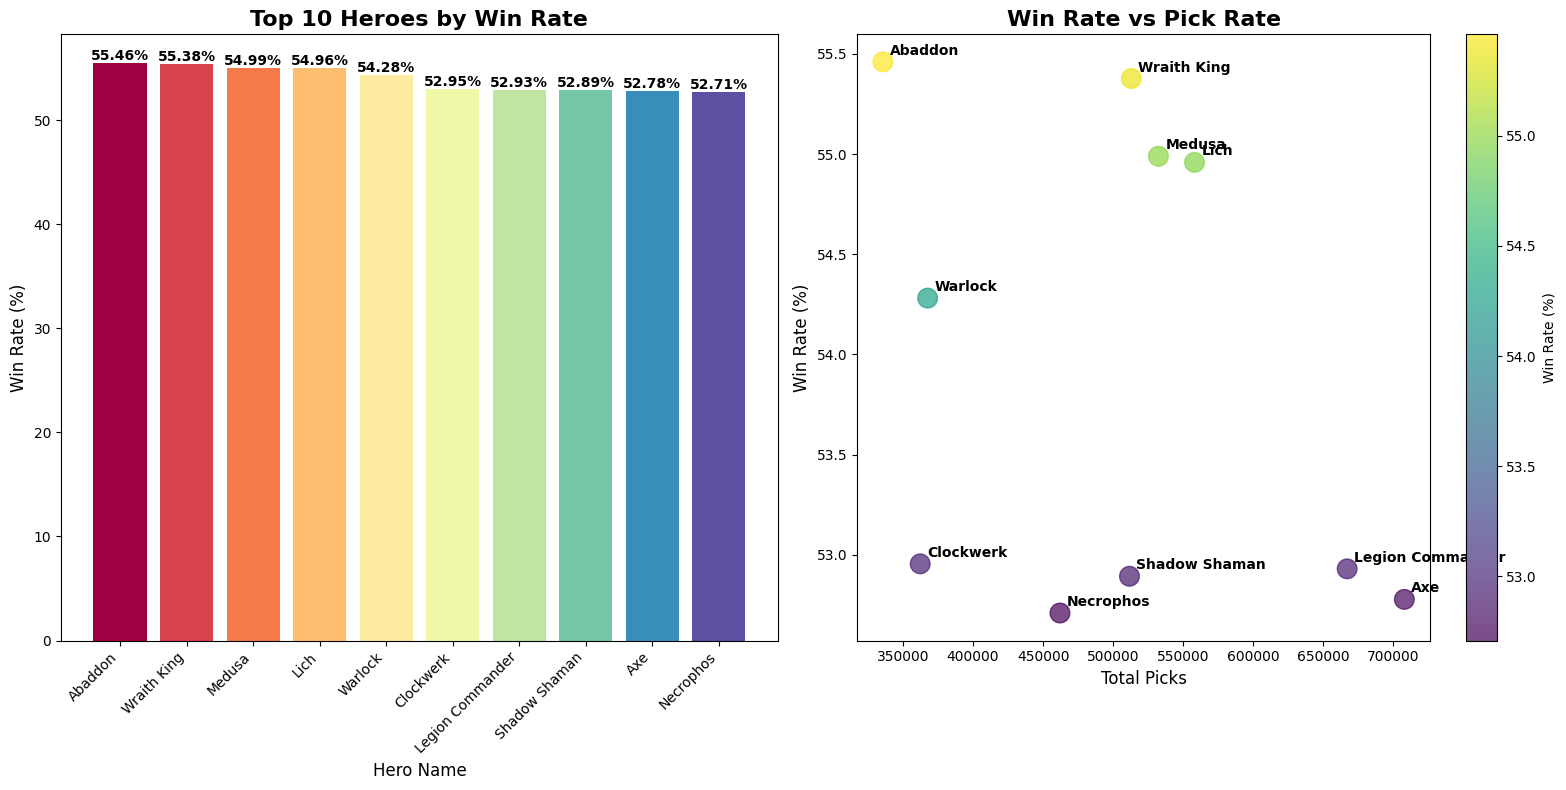


Detailed Hero Performance:
 Rank             Hero  Win Rate (%)  Total Picks
    1          Abaddon     55.460174       335612
    2      Wraith King     55.377056       513041
    3           Medusa     54.989058       532375
    4             Lich     54.958348       558190
    5          Warlock     54.280864       367566
    6        Clockwerk     52.954313       362267
    7 Legion Commander     52.929424       667179
    8    Shadow Shaman     52.892252       511712
    9              Axe     52.776977       708036
   10        Necrophos     52.708873       462074


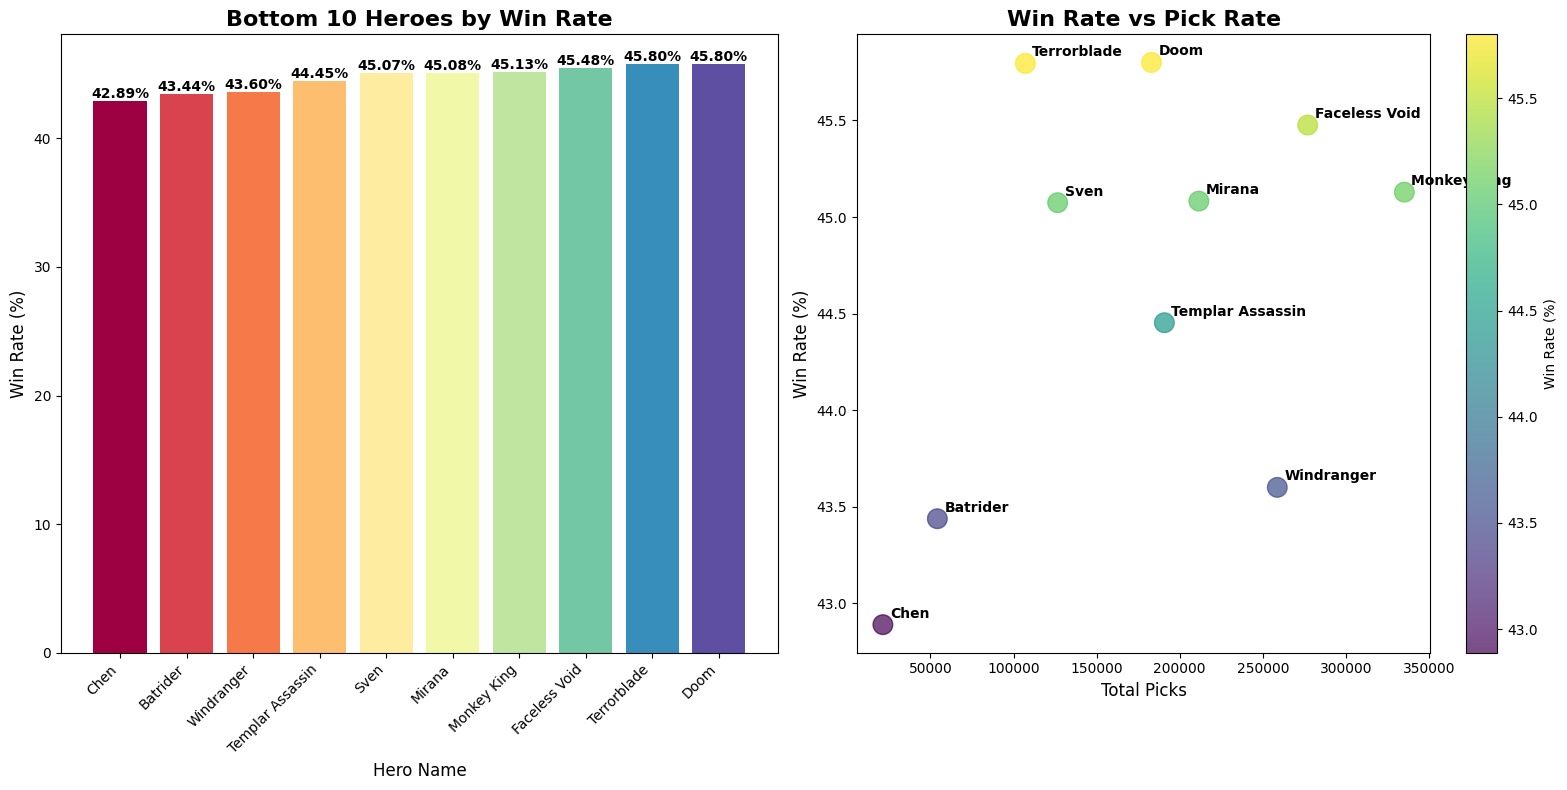


Detailed Hero Performance:
 Rank             Hero  Win Rate (%)  Total Picks
    1             Chen     42.888484        21423
    2         Batrider     43.437177        54184
    3       Windranger     43.599536       258700
    4 Templar Assassin     44.452540       190781
    5             Sven     45.074240       126549
    6           Mirana     45.082568       211523
    7      Monkey King     45.128836       335156
    8    Faceless Void     45.476468       277007
    9      Terrorblade     45.795649       107139
   10             Doom     45.800684       183006


In [294]:
import matplotlib.pyplot as plt
import seaborn as sns

def hero_winrate_visualization(top_10_heroes, key_word):
    # Set up the plot with a clean, modern style
    plt.figure(figsize=(16, 8))
    #plt.style.use('seaborn')

    # Create a bar plot with additional details
    plt.subplot(1, 2, 1)
    bars = plt.bar(top_10_heroes['localized_name'], top_10_heroes['pub_winrate'], 
                   color=plt.cm.Spectral(np.linspace(0, 1, 10)))
    
    # Customize the bar plot
    plt.title(f'{key_word} 10 Heroes by Win Rate', fontsize=16, fontweight='bold')
    plt.xlabel('Hero Name', fontsize=12)
    plt.ylabel('Win Rate (%)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}%', 
                 ha='center', va='bottom', fontweight='bold')

    # Create a scatter plot to show relationship between win rate and picks
    plt.subplot(1, 2, 2)
    scatter = plt.scatter(top_10_heroes['pub_pick'], top_10_heroes['pub_winrate'], 
                          c=top_10_heroes['pub_winrate'], 
                          cmap='viridis', 
                          s=200, 
                          alpha=0.7)
    
    # Annotate each point with hero name
    for i, row in top_10_heroes.iterrows():
        plt.annotate(row['localized_name'], 
                     (row['pub_pick'], row['pub_winrate']),
                     xytext=(5, 5),
                     textcoords='offset points',
                     fontweight='bold')
    
    plt.colorbar(scatter, label='Win Rate (%)')
    plt.title('Win Rate vs Pick Rate', fontsize=16, fontweight='bold')
    plt.xlabel('Total Picks', fontsize=12)
    plt.ylabel('Win Rate (%)', fontsize=12)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

    # Additional detailed table
    print("\nDetailed Hero Performance:")
    detailed_table = top_10_heroes.copy()
    detailed_table['Rank'] = range(1, len(detailed_table) + 1)
    detailed_table = detailed_table[['Rank', 'localized_name', 'pub_winrate', 'pub_pick']]
    detailed_table.columns = ['Rank', 'Hero', 'Win Rate (%)', 'Total Picks']
    print(detailed_table.to_string(index=False))

# Assuming df_hero_winrate is your dataframe
top_10_heroes = df_hero_winrate.nlargest(10, 'pub_winrate')[['localized_name', 'pub_winrate', 'pub_pick']]
hero_winrate_visualization(top_10_heroes, 'Top')
hero_winrate_visualization(bottom_10_heroes, 'Bottom')

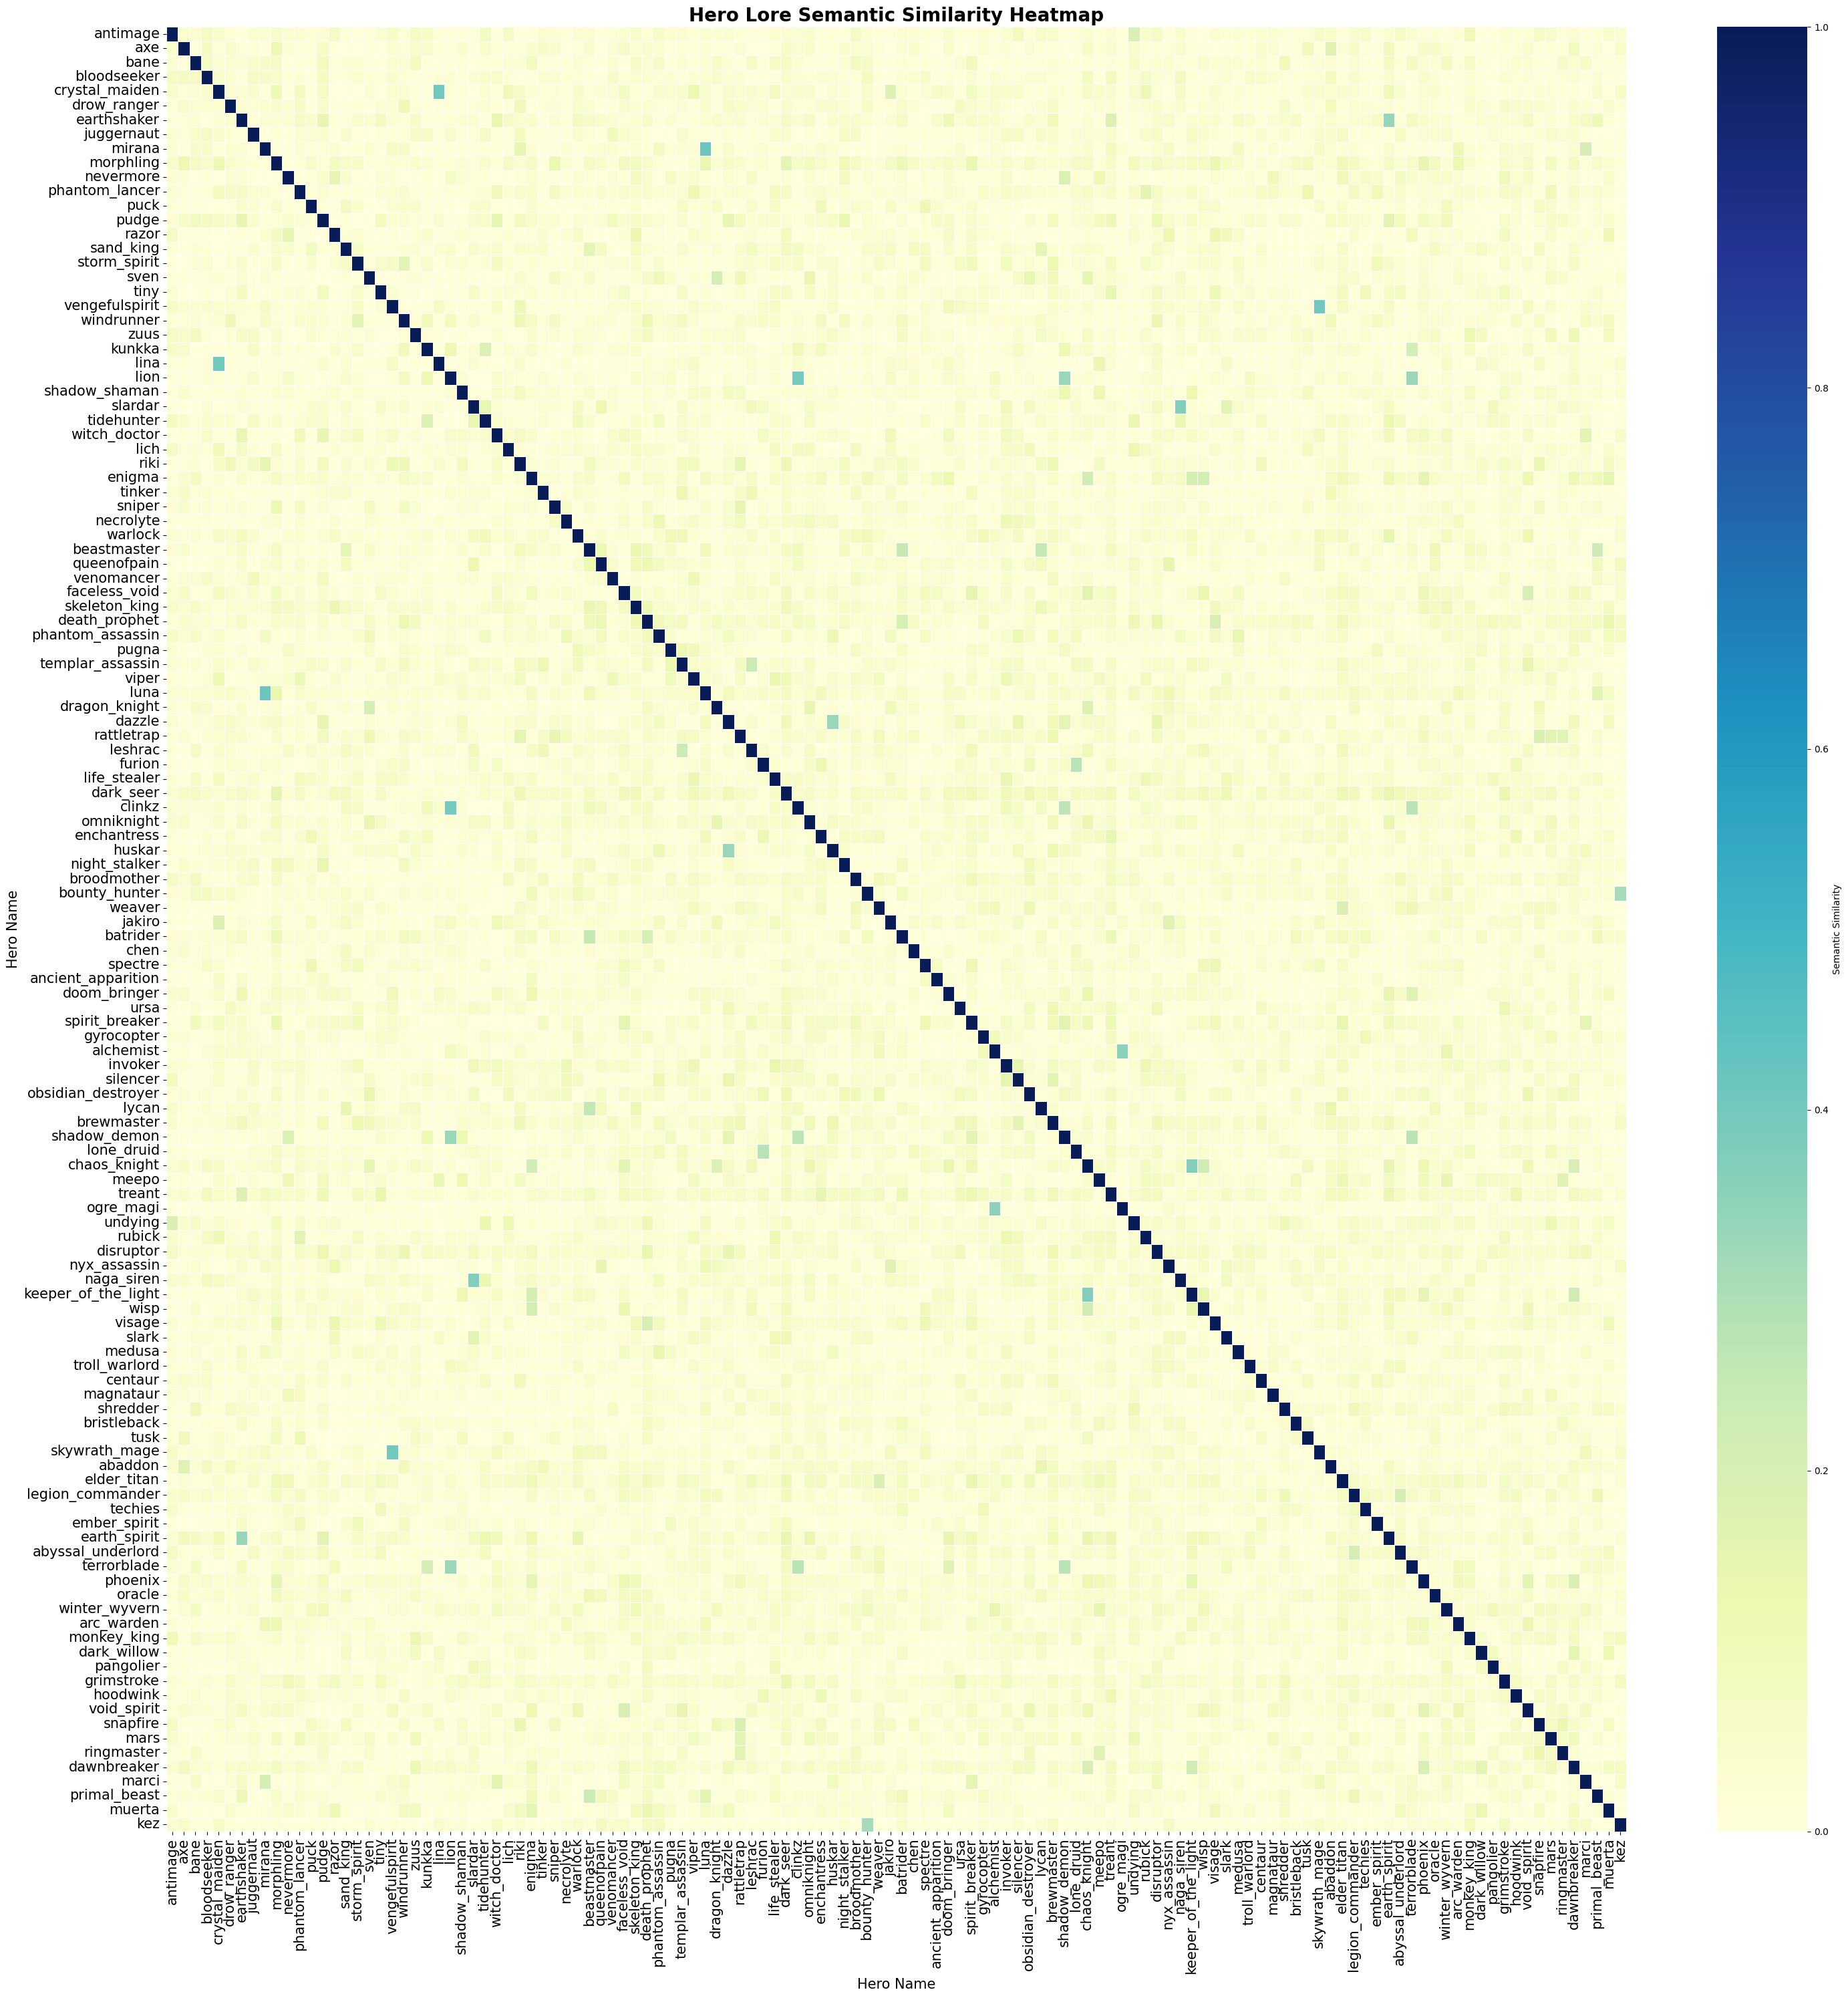

In [295]:
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

def hero_lore_semantic_analysis(hero_data, n_clusters=5):
    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    lore_vectors = vectorizer.fit_transform(hero_data['lore'])
    
    # Cosine Similarity Matrix
    similarity_matrix = cosine_similarity(lore_vectors)
    
    # # Clustering (using KMeans to group heroes based on lore)
    # kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    # hero_data['lore_cluster'] = kmeans.fit_predict(lore_vectors)

    # Visualization of the semantic similarity matrix as a heatmap
    plt.figure(figsize=(30, 30))
    
    # Heatmap (sns.heatmap is often more visually appealing and provides more options)
    sns.heatmap(similarity_matrix, cmap='YlGnBu', annot=False, xticklabels=hero_data['name'], yticklabels=hero_data['name'], cbar_kws={'label': 'Semantic Similarity'}, linewidths=0.5)
    
    # Title and Axis Labels
    plt.title('Hero Lore Semantic Similarity Heatmap', fontsize=20, fontweight='bold')
    plt.xlabel('Hero Name', fontsize=15)
    plt.ylabel('Hero Name', fontsize=15)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90, fontsize=15)
    plt.yticks(rotation=0, fontsize=15)
    
    # Tight layout to ensure labels are not cut off
    plt.tight_layout()
    plt.show()
    
    # # Print out cluster representatives (i.e., heroes within each cluster)
    # for cluster in range(n_clusters):
    #     print(f"\nCluster {cluster} Representatives:")
    #     cluster_heroes = hero_data[hero_data['lore_cluster'] == cluster]
    #     print(cluster_heroes[['name', 'lore']].sample(min(3, len(cluster_heroes))))
    
    #return hero_data, similarity_matrix

# Load the JSON file
file_path = '/home/ad-magus-apex/Downloads/Q4/EDA/Dota-Stats/data/hero_data/hero_lore/hero_lore.json'

with open(file_path, 'r') as f:
    hero_lore = json.load(f)

# Convert JSON to DataFrame
df_hero_lore = pd.DataFrame(list(hero_lore.items()), columns=['name', 'lore'])

# Run semantic analysis
hero_lore_semantic_analysis(df_hero_lore)


In [296]:
# from sklearn.decomposition import LatentDirichletAllocation

# def topic_modeling(hero_data, n_topics=5):
#     vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
#     lore_vectors = vectorizer.fit_transform(hero_data['lore'])
    
#     lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
#     lda.fit(lore_vectors)
    
#     # Print the top words in each topic
#     feature_names = vectorizer.get_feature_names_out()
#     for topic_idx, topic in enumerate(lda.components_):
#         print(f"Topic #{topic_idx}:")
#         print(" ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))  # top 10 words per topic
    
#     return lda

# lda_model = topic_modeling(df_hero_lore)


In [298]:
region_offsets = {
    1: -8,   # US WEST
    2: -5,   # US EAST
    3: +1,   # EUROPE
    5: +8,   # SINGAPORE
    6: +4,   # DUBAI
    7: +10,  # AUSTRALIA
    8: +1,   # STOCKHOLM
    9: +1,   # AUSTRIA
    10: -3,  # BRAZIL
    11: +2,  # SOUTH AFRICA
    12: +8,  # PW TELECOM SHANGHAI
    13: +8,  # PW UNICOM
    14: -4,  # CHILE
    15: -5,  # PERU
    16: +5.5, # INDIA
    17: +8,  # PW TELECOM GUANGDONG
    18: +8,  # PW TELECOM ZHEJIANG
    19: +9,  # JAPAN
    20: +8,  # PW TELECOM WUHAN
    25: +8,  # PW UNICOM TIANJIN
    37: +8,  # TAIWAN
    38: -3   # ARGENTINA
}
df_pub_matches['hour'] = df_pub_matches['start_time'].dt.hour

def adjust_hour_to_region(hour, region):
    utc_offset = region_offsets.get(region, 0)  # Default offset is 0 if region is not in mapping
    local_hour = (hour + utc_offset) % 24  # Adjust hour and wrap around with modulo 24
    return local_hour

# Apply the conversion
df_pub_matches['local_hour'] = df_pub_matches.apply(lambda row: adjust_hour_to_region(row['hour'], row['region']), axis=1)

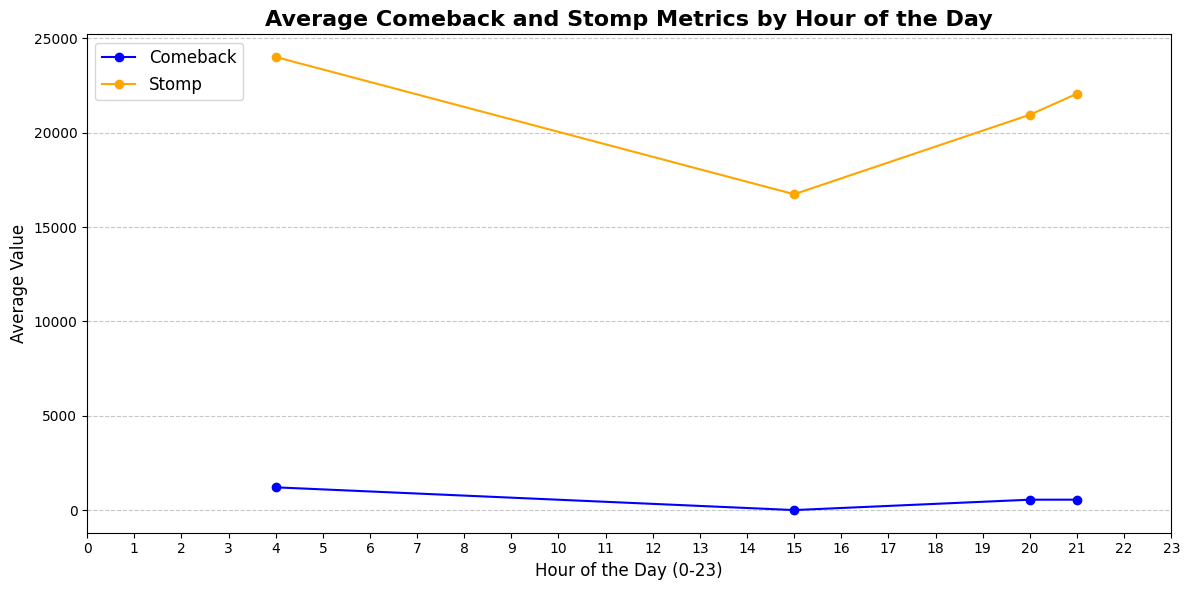

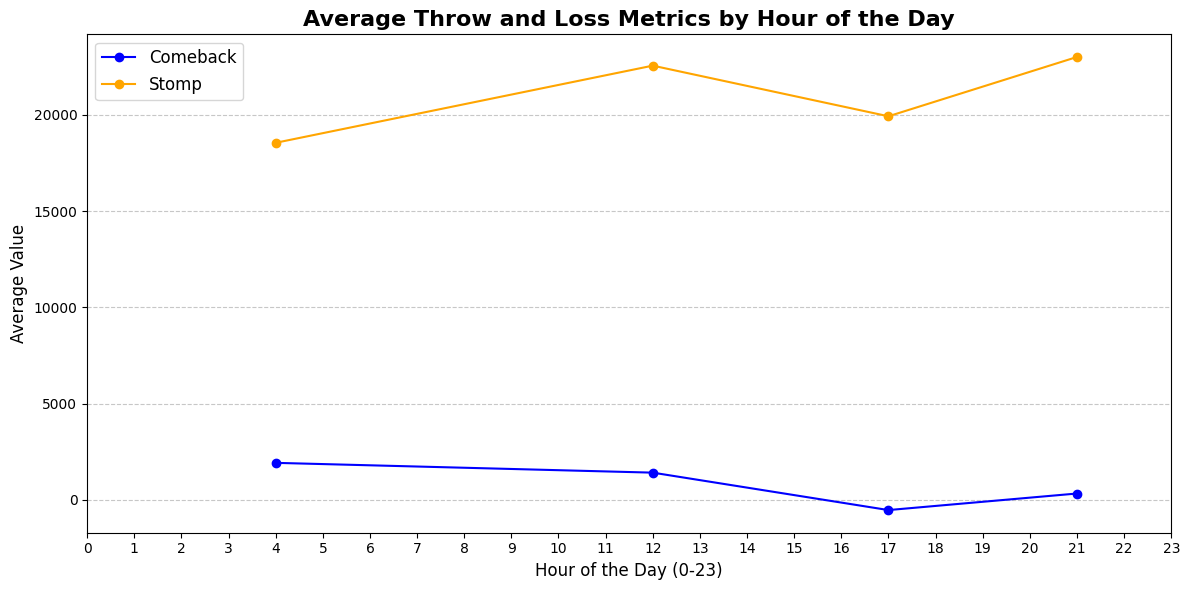

In [299]:

df_data_hourly = df_pub_matches.dropna(subset=['comeback']).groupby('local_hour')[['comeback', 'stomp']].mean().reset_index()

# Plot the data
plt.figure(figsize=(12, 6))

# Plot 'comeback'
plt.plot(df_data_hourly['local_hour'], df_data_hourly['comeback'], label='Comeback', marker='o', linestyle='-', color='blue')

# Plot 'stomp'
plt.plot(df_data_hourly['local_hour'], df_data_hourly['stomp'], label='Stomp', marker='o', linestyle='-', color='orange')

# Customize the plot
plt.title('Average Comeback and Stomp Metrics by Hour of the Day', fontsize=16, fontweight='bold')
plt.xlabel('Hour of the Day (0-23)', fontsize=12)
plt.ylabel('Average Value', fontsize=12)
plt.xticks(range(24), fontsize=10)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

df_data_hourly = df_pub_matches.dropna(subset=['throw']).groupby('local_hour')[['throw', 'loss']].mean().reset_index()

# Plot the data
plt.figure(figsize=(12, 6))

# Plot 'Throw'
plt.plot(df_data_hourly['local_hour'], df_data_hourly['throw'], label='Comeback', marker='o', linestyle='-', color='blue')

# Plot 'Loss'
plt.plot(df_data_hourly['local_hour'], df_data_hourly['loss'], label='Stomp', marker='o', linestyle='-', color='orange')

# Customize the plot
plt.title('Average Throw and Loss Metrics by Hour of the Day', fontsize=16, fontweight='bold')
plt.xlabel('Hour of the Day (0-23)', fontsize=12)
plt.ylabel('Average Value', fontsize=12)
plt.xticks(range(24), fontsize=10)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

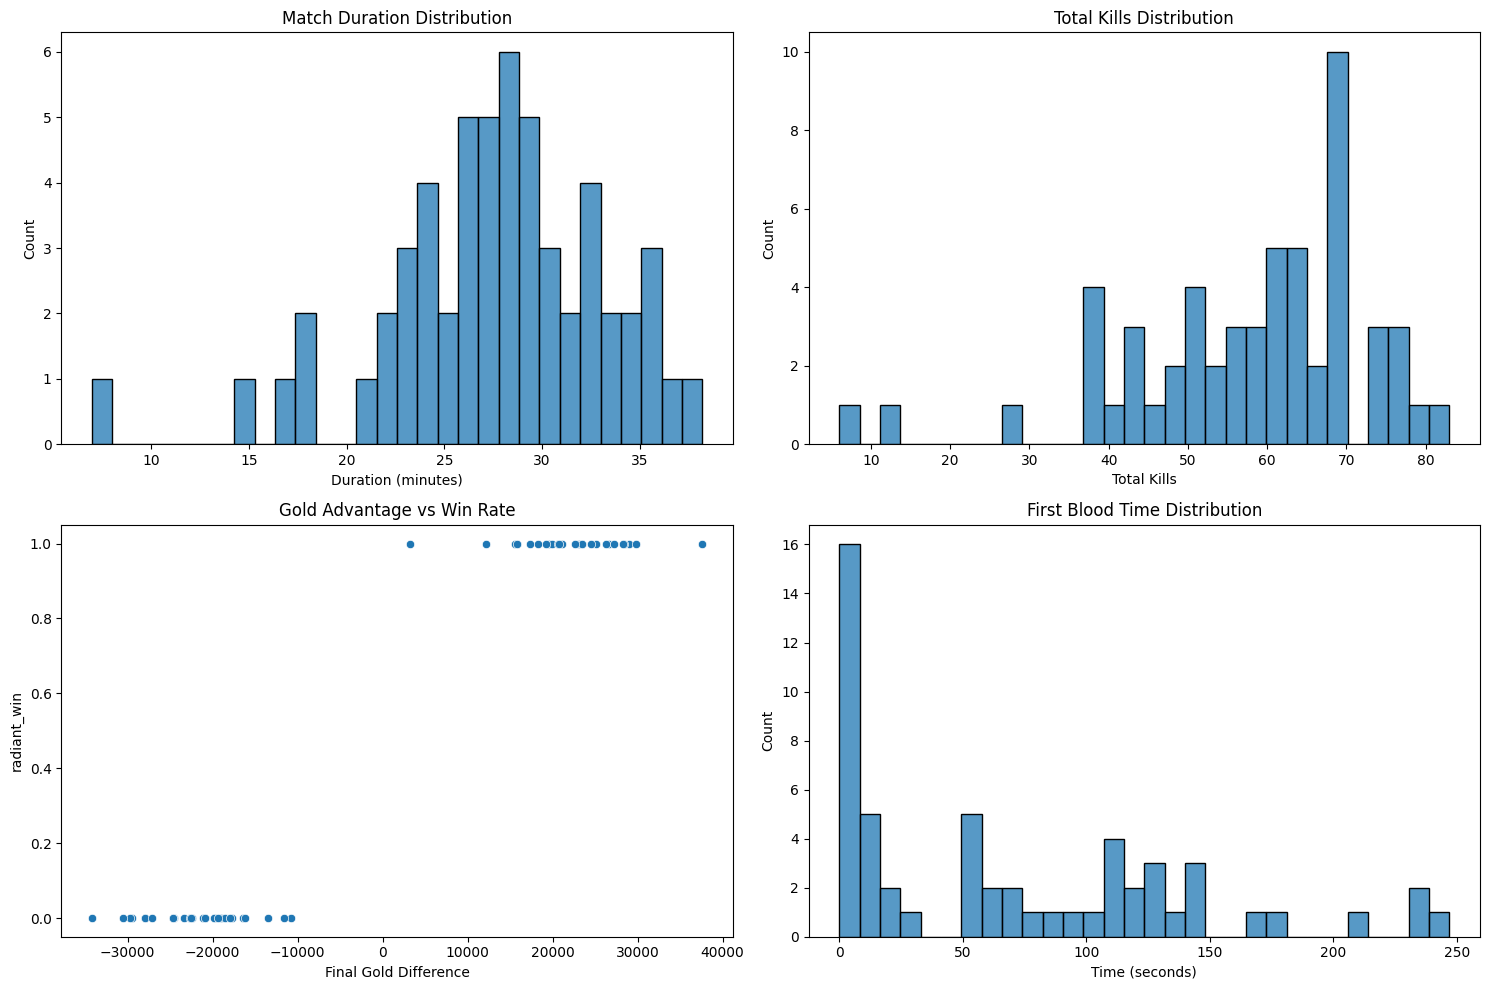

In [300]:
# Here is some early analysis on the prepared data.

def early_analysis(df):
    """
    Comprehensive analysis of Dota 2 match data

    Parameters:
    df (pandas.DataFrame): DataFrame containing Dota 2 match data
    """
    # Data Cleaning
    def clean_list_columns(x):
        if isinstance(x, str):
            # Remove brackets and split string into list
            return [float(i) for i in x.strip('[]').split(',') if i]
        return x

    # Convert string representations of lists to actual lists
    df['radiant_gold_adv'] = df['radiant_gold_adv'].apply(clean_list_columns)
    df['radiant_xp_adv'] = df['radiant_xp_adv'].apply(clean_list_columns)

    # Convert timestamps to datetime
    df['start_time'] = pd.to_datetime(df['start_time'])

    # Create derived features
    df['match_length_minutes'] = df['duration'] / 60
    df['gold_difference_final'] = df['radiant_gold_adv'].apply(lambda x: x[-1] if isinstance(x, list) and len(x) > 0 else np.nan)
    df['xp_difference_final'] = df['radiant_xp_adv'].apply(lambda x: x[-1] if isinstance(x, list) and len(x) > 0 else np.nan)
    df['total_kills'] = df['radiant_score'] + df['dire_score']
    df['kill_difference'] = df['radiant_score'] - df['dire_score']

    # Analysis results
    analysis = {
        'basic_stats': {
            'total_matches': len(df),
            'radiant_win_rate': (df['radiant_win'].mean() * 100),
            'avg_match_duration': df['match_length_minutes'].mean(),
            'avg_first_blood_time': df['first_blood_time'].mean(),
            'avg_total_kills': df['total_kills'].mean()
        },
        'match_patterns': {
            'comeback_rate': (df['comeback'].mean() * 100),
            'stomp_rate': (df['stomp'].mean() * 100),
            'throw_rate': (df['throw'].mean() * 100)
        }
    }

    # Calculate win conditions
    analysis['win_conditions'] = {
        'gold_lead_win_rate': len(df[(df['gold_difference_final'] > 0) & (df['radiant_win'])] ) / len(df[df['gold_difference_final'] > 0]) * 100,
        'xp_lead_win_rate': len(df[(df['xp_difference_final'] > 0) & (df['radiant_win'])] ) / len(df[df['xp_difference_final'] > 0]) * 100
    }

    return analysis

def plot_match_metrics(df):
    """
    Create visualizations for key match metrics
    """
    plt.figure(figsize=(15, 10))

    # Plot 1: Match Duration Distribution
    plt.subplot(2, 2, 1)
    sns.histplot(df['match_length_minutes'], bins=30)
    plt.title('Match Duration Distribution')
    plt.xlabel('Duration (minutes)')

    # Plot 2: Kill Distribution
    plt.subplot(2, 2, 2)
    sns.histplot(df['total_kills'], bins=30)
    plt.title('Total Kills Distribution')
    plt.xlabel('Total Kills')

    # Plot 3: Gold Advantage vs Win Rate
    plt.subplot(2, 2, 3)
    sns.scatterplot(data=df, x='gold_difference_final', y='radiant_win')
    plt.title('Gold Advantage vs Win Rate')
    plt.xlabel('Final Gold Difference')

    # Plot 4: First Blood Time Distribution
    plt.subplot(2, 2, 4)
    sns.histplot(df['first_blood_time'], bins=30)
    plt.title('First Blood Time Distribution')
    plt.xlabel('Time (seconds)')

    plt.tight_layout()
    return plt

analysis_results = early_analysis(df_pub_matches)
plots = plot_match_metrics(df_pub_matches)

In [301]:
df_pub_matches[['radiant_heros', 'dire_heros', 'radiant_party_size','dire_party_size']] = df_players['players'].apply(
    lambda players: pd.Series({
        'radiant_heros': [player['hero_id'] for player in players if player['team_number'] == 1],
        'dire_heros': [player['hero_id'] for player in players if player['team_number'] == 0],
        'radiant_party_size': [player['party_size'] for player in players if player['team_number'] == 1],
        'dire_party_size': [player['party_size'] for player in players if player['team_number'] == 0],
    })
)

In [302]:
df_pub_matches['radiant_party_size'] = df_pub_matches['radiant_party_size'].apply(max)
df_pub_matches['dire_party_size'] = df_pub_matches['dire_party_size'].apply(max)

In [303]:
df_pub_matches.columns

Index(['match_id', 'radiant_gold_adv', 'radiant_xp_adv', 'start_time',
       'duration', 'cluster', 'replay_salt', 'radiant_win',
       'pre_game_duration', 'tower_status_radiant', 'tower_status_dire',
       'barracks_status_radiant', 'barracks_status_dire', 'first_blood_time',
       'lobby_type', 'game_mode', 'flags', 'radiant_score', 'dire_score',
       'metadata', 'patch', 'region', 'comeback', 'stomp', 'throw', 'loss',
       'Winner', 'hour', 'local_hour', 'match_length_minutes',
       'gold_difference_final', 'xp_difference_final', 'total_kills',
       'kill_difference', 'radiant_heros', 'dire_heros', 'radiant_party_size',
       'dire_party_size'],
      dtype='object')

In [304]:
# Initialize a dictionary to store hero combinations with their win/loss counts
hero_combination_stats = defaultdict(lambda: {'win': 0, 'lose': 0})
party_stats = defaultdict(lambda: {'win':0, 'lose':0, 'comeback':0, 'throw':0, 'loss':0, 'stomp':0, 'radiant_win':0, 'dire_win':0})
# Iterate through each match in df_pub_matches
for _, match in df_pub_matches.iterrows():

    # Get the sorted hero combinations for Radiant and Dire
    radiant_comb = tuple(sorted(match['radiant_heros']))
    dire_comb = tuple(sorted(match['dire_heros']))

    radiant_party_size = match['radiant_party_size']
    dire_party_size = match['dire_party_size']
    
    # Update stats for Radiant team
    if match['radiant_win']:  # Radiant won
        party_stats[radiant_party_size]['radiant_win'] += 1
        party_stats[radiant_party_size]['win'] += 1
        party_stats[dire_party_size]['lose'] += 1

        hero_combination_stats[radiant_comb]['win'] += 1
        hero_combination_stats[dire_comb]['lose'] += 1

        party_stats[radiant_party_size]['throw'] += match['throw']
        party_stats[radiant_party_size]['loss'] += match['loss']
    else:  # Dire won
        party_stats[radiant_party_size]['dire_win'] += 1
        party_stats[radiant_party_size]['lose'] += 1
        party_stats[dire_party_size]['win'] += 1

        party_stats[dire_party_size]['comeback'] += match['comeback']
        party_stats[dire_party_size]['stomp'] += match['stomp']

        hero_combination_stats[radiant_comb]['lose'] += 1
        hero_combination_stats[dire_comb]['win'] += 1

    party_stats['trow_devisor'] = party_stats[radiant_party_size]['win']
    party_stats['comeback_devisor'] = party_stats[dire_party_size]['win']
# Convert the dictionary to a DataFrame
df_hero_combination = pd.DataFrame([
    {'hero_combination': comb, 'win': stats['win'], 'lose': stats['lose']}#, 'radiant_win':stats['radiant_win'], 'dire_win':stats['dire_win']}
    for comb, stats in hero_combination_stats.items()
])
print(party_stats)
df_party_stats = pd.DataFrame([
    {
        'party_size': ps,
        'win': stats['win'],
        'lose': stats['lose'],
        'mean_comeback': stats['comeback'] / stats['dire_win'] if stats['dire_win'] > 0 else 0,
        'mean_stomp': stats['stomp'] / stats['dire_win'] if stats['dire_win'] > 0 else 0,
        'mean_loss': stats['loss'] / stats['radiant_win'] if stats['radiant_win'] > 0 else 0,
        'mean_throw': stats['throw'] / stats['radiant_win'] if stats['radiant_win'] > 0 else 0
    }
    for ps, stats in party_stats.items() if isinstance(ps, int)  # Filter only party size keys
])

# Sort by wins or other criteria if needed
df_hero_combination.sort_values(by='win', ascending=False, inplace=True)
df_party_stats.sort_values(by='party_size', ascending=True, inplace=True)

# Reset index for cleaner display
df_hero_combination.reset_index(drop=True, inplace=True)
df_party_stats.reset_index(drop=True, inplace=True)

print(df_hero_combination)

df_party_stats['win_rate'] = (df_party_stats['win'] / df_party_stats['lose']) * 100


defaultdict(<function <lambda> at 0x7a9b344a9990>, {3: {'win': 8, 'lose': 7, 'comeback': 3254.0, 'throw': 630.0, 'loss': 57575.0, 'stomp': 114606.0, 'radiant_win': 3, 'dire_win': 4}, 'trow_devisor': 29, 'comeback_devisor': 29, 2: {'win': 13, 'lose': 14, 'comeback': 1677.0, 'throw': -715.0, 'loss': 128508.0, 'stomp': 165454.0, 'radiant_win': 6, 'dire_win': 8}, 5: {'win': 6, 'lose': 5, 'comeback': 4781.0, 'throw': 226.0, 'loss': 72277.0, 'stomp': 65485.0, 'radiant_win': 3, 'dire_win': 2}, 1: {'win': 29, 'lose': 29, 'comeback': 7027.0, 'throw': 14502.0, 'loss': 349443.0, 'stomp': 291895.0, 'radiant_win': 15, 'dire_win': 14}, 4: {'win': 0, 'lose': 1, 'comeback': 0, 'throw': 0, 'loss': 0, 'stomp': 0, 'radiant_win': 0, 'dire_win': 1}})
           hero_combination  win  lose
0    (10, 35, 66, 104, 120)    1     0
1    (8, 35, 107, 129, 138)    1     0
2    (2, 67, 106, 123, 138)    1     0
3     (32, 37, 49, 60, 110)    1     0
4      (7, 44, 87, 97, 110)    1     0
..                      ..

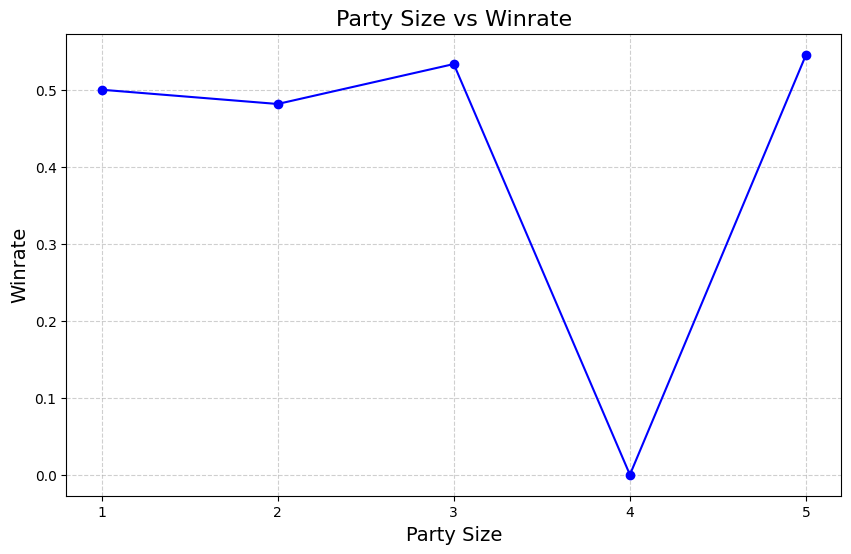

In [305]:
import matplotlib.pyplot as plt

# Add a winrate column to df_party_stats
df_party_stats['winrate'] = df_party_stats['win'] / (df_party_stats['win'] + df_party_stats['lose'])

# Plot Party Size vs Winrate
plt.figure(figsize=(10, 6))
plt.plot(df_party_stats['party_size'], df_party_stats['winrate'], marker='o', linestyle='-', color='blue')
plt.title('Party Size vs Winrate', fontsize=16)
plt.xlabel('Party Size', fontsize=14)
plt.ylabel('Winrate', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(df_party_stats['party_size'])
plt.show()


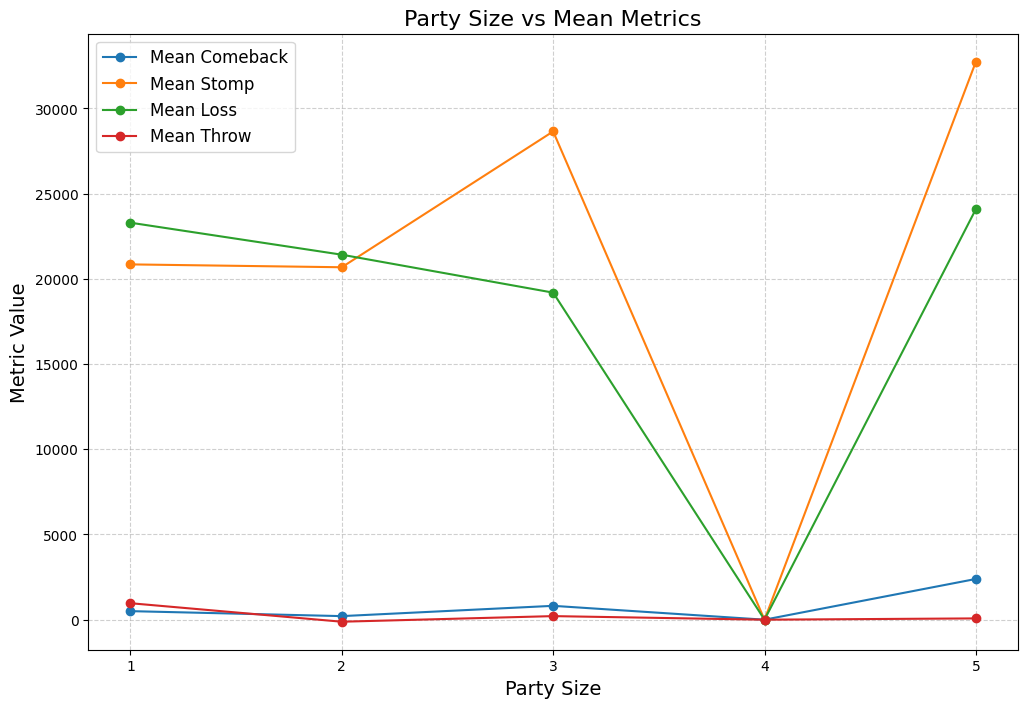

In [306]:
# Plot Party Size vs Mean Metrics
plt.figure(figsize=(12, 8))

# Plot each metric
plt.plot(df_party_stats['party_size'], df_party_stats['mean_comeback'], marker='o', linestyle='-', label='Mean Comeback')
plt.plot(df_party_stats['party_size'], df_party_stats['mean_stomp'], marker='o', linestyle='-', label='Mean Stomp')
plt.plot(df_party_stats['party_size'], df_party_stats['mean_loss'], marker='o', linestyle='-', label='Mean Loss')
plt.plot(df_party_stats['party_size'], df_party_stats['mean_throw'], marker='o', linestyle='-', label='Mean Throw')

# Customize plot
plt.title('Party Size vs Mean Metrics', fontsize=16)
plt.xlabel('Party Size', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(df_party_stats['party_size'])
plt.show()


In [307]:
df_pub_matches_all_pick = df_pub_matches[(df_pub_matches['game_mode'] == 22) | (df_pub_matches['game_mode'] == 4)].reset_index(drop=True)
df_pub_matches_turbo = df_pub_matches[df_pub_matches['game_mode'] == 23].reset_index(drop=True)